In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN









In [3]:

df = pd.read_csv("Data/instagram_data.csv")
df.isnull().sum()  # Check missing values
df.fillna(0, inplace=True)  # Replace NaNs with 0 if applicable
df = df[df['verified'] != 1]
df = df[df['user_id'] != 0]


In [4]:
print(df.head())

                user_id          name  posts followers following    PVT  \
0         ronaldo.prime  Cristiano 🐐🙌  1,844      124K       403  False   
2  ronaldo_cr7_fan_____          cr 7    131     54.6K         7  False   
4         cr_7.ronalddo  Ronaldo cr.7      5       114        11  False   
5              artagael  Abagael West     20       111       291  False   
6              abhagael       Abagael     26        62       329  False   

     date_joined  former_usernames  verified  
0  November 2020               3.0         0  
2    August 2022               4.0         0  
4  November 2021               3.0         0  
5    August 2017               0.0         0  
6     March 2024               2.0         0  


In [5]:
df['date_joined'] = pd.to_datetime(df['date_joined'].astype(str) + "-01", format="%B %Y-%d", errors='coerce')
df['account_age'] = (pd.Timestamp.now() - df['date_joined']).dt.days

In [6]:
print(df.head())

                user_id          name  posts followers following    PVT  \
0         ronaldo.prime  Cristiano 🐐🙌  1,844      124K       403  False   
2  ronaldo_cr7_fan_____          cr 7    131     54.6K         7  False   
4         cr_7.ronalddo  Ronaldo cr.7      5       114        11  False   
5              artagael  Abagael West     20       111       291  False   
6              abhagael       Abagael     26        62       329  False   

  date_joined  former_usernames  verified  account_age  
0  2020-11-01               3.0         0         1576  
2  2022-08-01               4.0         0          938  
4  2021-11-01               3.0         0         1211  
5  2017-08-01               0.0         0         2764  
6  2024-03-01               2.0         0          360  


In [7]:
def convert_k_notation(value):
    if pd.isna(value):
        return 0
    value = str(value).replace(',', '')
    value = str(value).replace('.', '')
    if 'K' in value:
        return int(float(value.replace('K', '')) * 1000)
    if 'M' in value:
        return int(float(value.replace('M', '')) * 1000000)
    return int(value)

df['followers'] = df['followers'].apply(convert_k_notation)
df['following'] = df['following'].apply(convert_k_notation)

### **Step 3: Convert Private/Public (PVT) to Binary**
df['PVT'] = df['PVT'].astype(bool).astype(int)  # False → 0 (Public), True → 1 (Private)

#  F/F Ratio
df['followers_following_ratio'] = (df['followers'] + 1) / (df['following'] + 1)

df['posts'] = pd.to_numeric(df['posts'], errors='coerce')

df['is_low_activity'] = df['posts'] < 3
df['is_high_activity'] = df['posts'] > 5000

# Display processed data
print(df.head())

                user_id          name  posts  followers  following  PVT  \
0         ronaldo.prime  Cristiano 🐐🙌    NaN     124000        403    0   
2  ronaldo_cr7_fan_____          cr 7  131.0     546000          7    0   
4         cr_7.ronalddo  Ronaldo cr.7    5.0        114         11    0   
5              artagael  Abagael West   20.0        111        291    0   
6              abhagael       Abagael   26.0         62        329    0   

  date_joined  former_usernames  verified  account_age  \
0  2020-11-01               3.0         0         1576   
2  2022-08-01               4.0         0          938   
4  2021-11-01               3.0         0         1211   
5  2017-08-01               0.0         0         2764   
6  2024-03-01               2.0         0          360   

   followers_following_ratio  is_low_activity  is_high_activity  
0                 306.933168            False             False  
2               68250.125000            False             False  
4 

In [8]:
def detect_fake_username(user_id):
    if re.search(r'\d{5,}', user_id):  # More than 5 consecutive numbers
        return 1
    if re.search(r'(.)\1{2,}', user_id):  # Repeated letters (aaa, 111)
        return 1
    if len(user_id) < 3:  # Too short
        return 1
    return 0

df['user_id'] = df['user_id'].astype(str)

df['fake_username'] = df['user_id'].apply(detect_fake_username)


In [9]:
def detect_fake_name(name):
    if len(name) < 3 or len(name) > 25:
        return 1
    if re.search(r'[^\w\s]', name):  # Special characters
        return 1
    return 0

df['name'] = df['name'].astype(str)


df['fake_name'] = df['name'].apply(detect_fake_name)

In [10]:
# Select numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Select string (categorical) columns
string_df = df.select_dtypes(include=[object])

# Display the first few rows of each DataFrame
print("Numeric DataFrame:")
print(numeric_df.head())

print("\nString DataFrame:")
print(string_df.head())

Numeric DataFrame:
   posts  followers  following  PVT  former_usernames  verified  account_age  \
0    NaN     124000        403    0               3.0         0         1576   
2  131.0     546000          7    0               4.0         0          938   
4    5.0        114         11    0               3.0         0         1211   
5   20.0        111        291    0               0.0         0         2764   
6   26.0         62        329    0               2.0         0          360   

   followers_following_ratio  fake_username  fake_name  
0                 306.933168              0          1  
2               68250.125000              1          0  
4                   9.583333              0          1  
5                   0.383562              0          0  
6                   0.190909              0          0  

String DataFrame:
                user_id          name
0         ronaldo.prime  Cristiano 🐐🙌
2  ronaldo_cr7_fan_____          cr 7
4         cr_7.ronalddo  

In [11]:
pd.options.display.float_format = '{:.2f}'.format
print("MEAN \n")
print(numeric_df.mean())
print("MEDIAN")
print(numeric_df.median())
print("MODE")
print(numeric_df.mode().iloc[0])
print("STD")
print(numeric_df.std())


MEAN 

posts                          152.77
followers                   357361.06
following                      371.62
PVT                              0.25
former_usernames                 1.59
verified                         0.00
account_age                   1737.09
followers_following_ratio    78105.30
fake_username                    0.11
fake_name                        0.28
dtype: float64
MEDIAN
posts                         42.00
followers                    856.00
following                    178.00
PVT                            0.00
former_usernames               1.00
verified                       0.00
account_age                 1591.50
followers_following_ratio      5.26
fake_username                  0.00
fake_name                      0.00
dtype: float64
MODE
posts                          0.00
followers                     26.00
following                      0.00
PVT                            0.00
former_usernames               0.00
verified                       

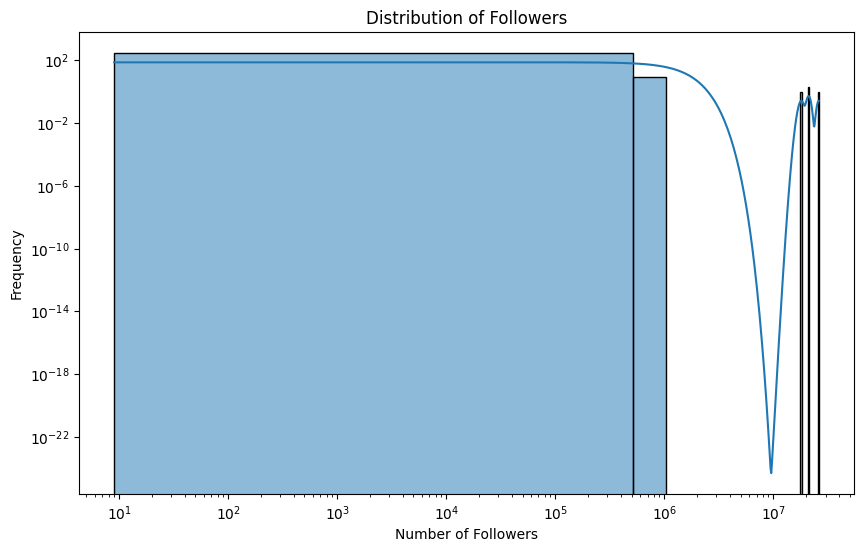

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(df['followers'], bins=50, kde=True)
plt.title('Distribution of Followers')
plt.xlabel('Number of Followers')
plt.ylabel('Frequency')
plt.xscale('log')  # Use a logarithmic scale for the x-axis
plt.yscale('log')  # Optionally, use a logarithmic scale for the y-axis
plt.show()

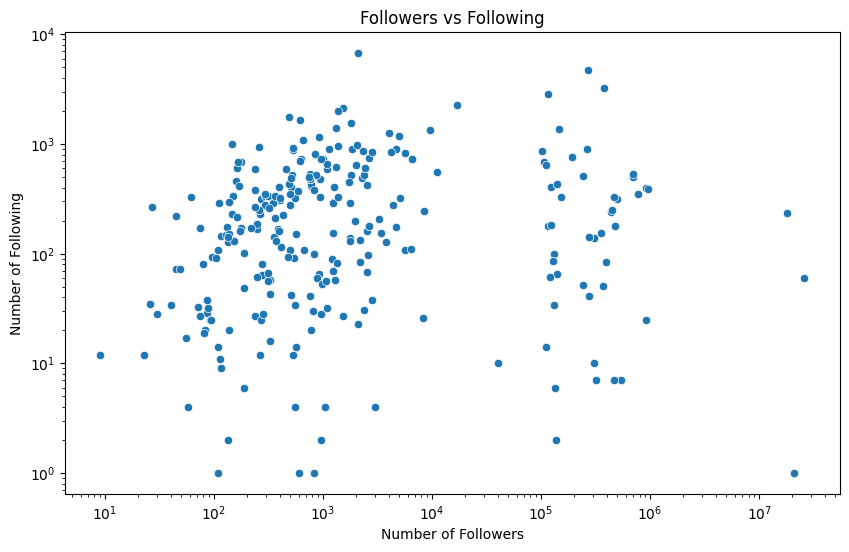

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='followers', y='following', data=df)
plt.title('Followers vs Following')
plt.xlabel('Number of Followers')
plt.ylabel('Number of Following')
plt.xscale('log')  # Use a logarithmic scale for the x-axis
plt.yscale('log')  # Optionally, use a logarithmic scale for the y-axis
plt.show()

In [14]:
# Ensure the necessary columns are numeric
df['followers'] = pd.to_numeric(df['followers'], errors='coerce')
df['following'] = pd.to_numeric(df['following'], errors='coerce')

# Drop rows with NaN values in the selected columns
df.dropna(subset=['followers', 'following'], inplace=True)

# Apply logarithm transformation to the data
df['log_followers'] = np.log1p(df['followers'])  # log1p is used to handle log(0)
df['log_following'] = np.log1p(df['following'])

# Prepare the data for clustering
X_log = df[['log_followers', 'log_following']].values

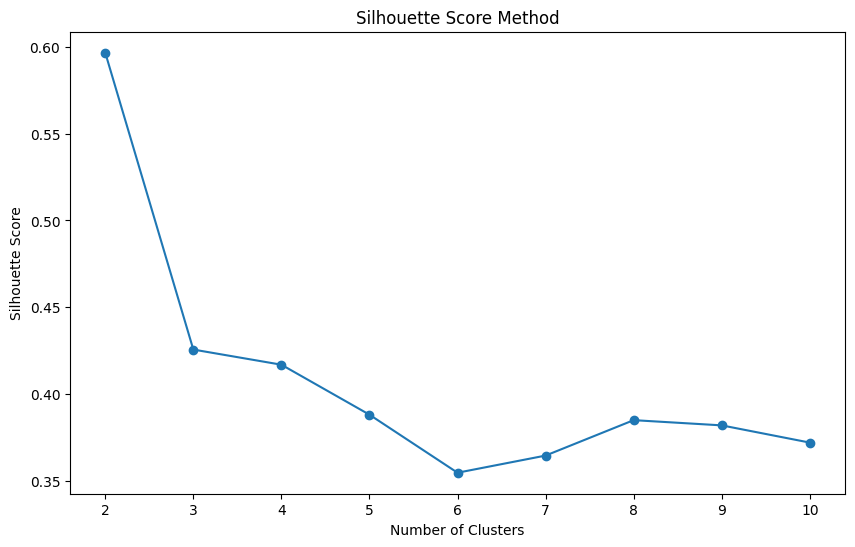

In [15]:
# Calculate silhouette scores for different values of n_clusters
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=50)
    kmeans.fit(X_log)
    score = silhouette_score(X_log, kmeans.labels_)
    silhouette_scores.append(score)

# Plot the Silhouette Score graph
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [16]:
# Determine the optimal number of clusters using the Elbow Method or Silhouette Score
optimal_clusters = 2  # Replace with the chosen number of clusters based on the methods above

# Fit the K-Means model
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X_log)

# Calculate the distance to the nearest cluster center
df['distance_to_center'] = np.min(kmeans.transform(X_log), axis=1)

# Identify outliers based on the distance to the nearest cluster center
threshold = np.percentile(df['distance_to_center'], 90)  # Adjust the percentile as needed
df['is_outlier'] = df['distance_to_center'] > threshold

# Display the first few rows of the DataFrame to verify the changes
print(df.head())

                user_id          name  posts  followers  following  PVT  \
0         ronaldo.prime  Cristiano 🐐🙌    NaN     124000        403    0   
2  ronaldo_cr7_fan_____          cr 7 131.00     546000          7    0   
4         cr_7.ronalddo  Ronaldo cr.7   5.00        114         11    0   
5              artagael  Abagael West  20.00        111        291    0   
6              abhagael       Abagael  26.00         62        329    0   

  date_joined  former_usernames  verified  account_age  \
0  2020-11-01              3.00         0         1576   
2  2022-08-01              4.00         0          938   
4  2021-11-01              3.00         0         1211   
5  2017-08-01              0.00         0         2764   
6  2024-03-01              2.00         0          360   

   followers_following_ratio  is_low_activity  is_high_activity  \
0                     306.93            False             False   
2                   68250.12            False             False   

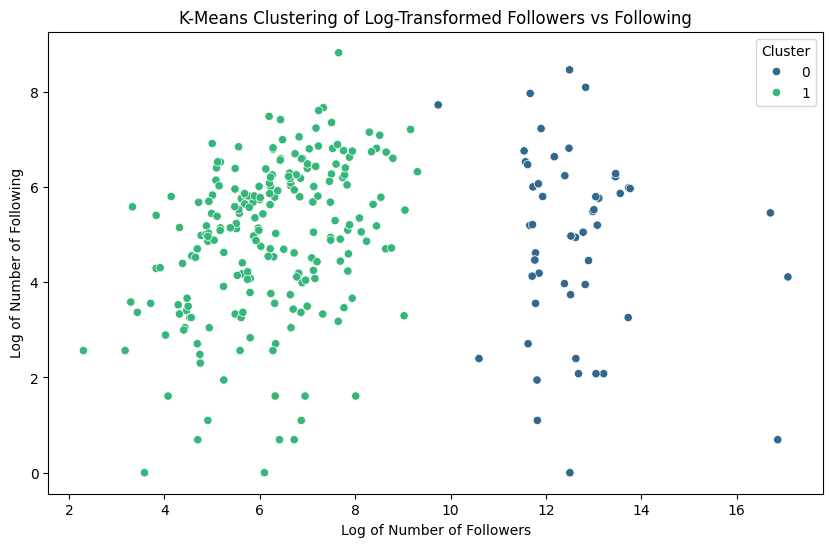

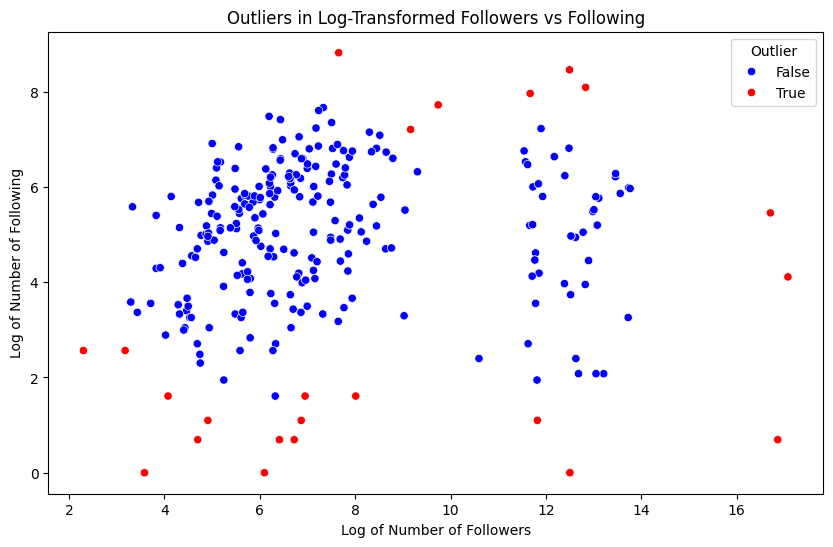

In [17]:
# Plot the clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='log_followers', y='log_following', hue='cluster', palette='viridis', data=df, legend='full')
plt.title('K-Means Clustering of Log-Transformed Followers vs Following')
plt.xlabel('Log of Number of Followers')
plt.ylabel('Log of Number of Following')
plt.legend(title='Cluster')
plt.show()

# Plot the outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(x='log_followers', y='log_following', hue='is_outlier', palette={False: 'blue', True: 'red'}, data=df, legend='full')
plt.title('Outliers in Log-Transformed Followers vs Following')
plt.xlabel('Log of Number of Followers')
plt.ylabel('Log of Number of Following')
plt.legend(title='Outlier')
plt.show()

In [ ]:
# Filter the DataFrame to get the outlier accounts
outliers_accounts_ff = df[df['is_outlier']]

# Display the outlier accounts
print(outliers_accounts_ff)

                            user_id                               name  posts  \
24            abbeys_playset_rental             Abbeys Play Set Rental    NaN   
80                   adarahofficial                       ADARAH INDIA 704.00   
96                      _adel_brand  Одежда |Мини Цех | Бишкек| Ателье 108.00   
110                   adelebabegirl                                  0 303.00   
139                     mazida__013                       🎶🎼🌻𝚖áᴢⲓ𝓭á🌻🎼🎶  45.00   
140                       mazida649                       Mazida Begum  87.00   
157                sonam.kashyap.14                      Sonam Kashyap   0.00   
173                     pooja.55770                       pooja sharma 910.00   
174        poojasharma.pooja.739978                 Pooja Sharma Pooja   0.00   
213       official___reenakhan__987                         𝙍𝙀𝙀𝙉𝘼 𝙆𝙃𝘼𝙉 782.00   
216                    reenaseema12                              reena 929.00   
218                   angel_

In [19]:
df.dropna(subset=['posts', 'account_age'], inplace=True)
# Select relevant features for clustering
features = ['posts', 'account_age']

# Convert features to numeric values if they are not already
df[features] = df[features].apply(pd.to_numeric, errors='coerce')

# Fill any remaining NaNs with 0
df[features].fillna(0, inplace=True)

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(df[features])

/tmp/ipykernel_136387/2821057486.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[features].fillna(0, inplace=True)


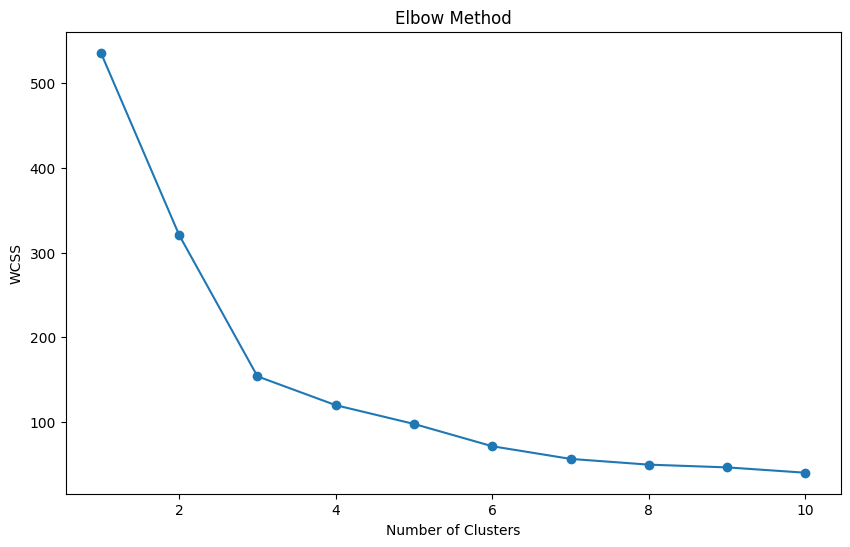

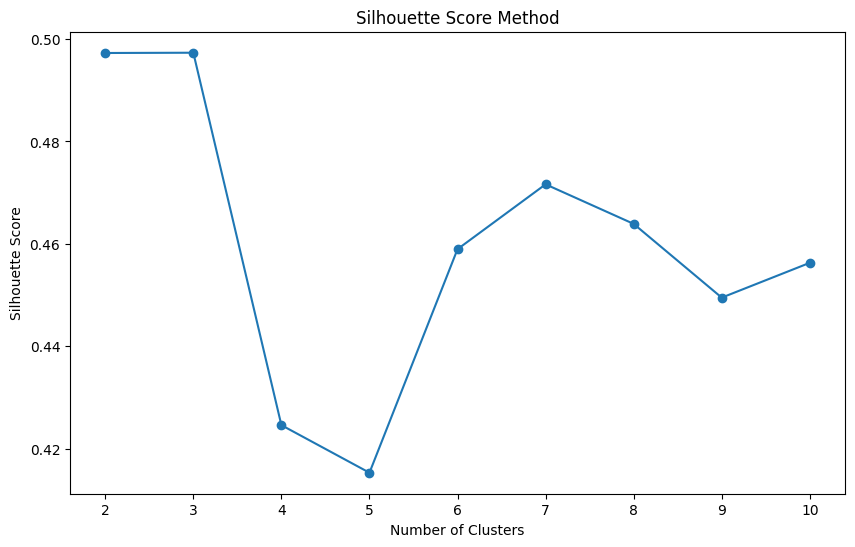

In [20]:
# Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Silhouette Score
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    cluster_labels = kmeans.predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Score graph
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [21]:
# Choose the optimal number of clusters based on the Elbow Method and Silhouette Score
optimal_clusters = 3  # Replace with the chosen number of clusters based on the methods above

# Fit the K-Means model with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Calculate the distance to the nearest cluster center
df['distance_to_center'] = np.min(kmeans.transform(X), axis=1)

# Identify outliers based on the distance to the nearest cluster center
threshold = np.percentile(df['distance_to_center'], 90)  # Adjust the percentile as needed
df['is_outlier'] = df['distance_to_center'] > threshold

# Display the first few rows of the DataFrame to verify the changes
print(df.head())

                user_id          name  posts  followers  following  PVT  \
2  ronaldo_cr7_fan_____          cr 7 131.00     546000          7    0   
4         cr_7.ronalddo  Ronaldo cr.7   5.00        114         11    0   
5              artagael  Abagael West  20.00        111        291    0   
6              abhagael       Abagael  26.00         62        329    0   
7             abagael._      Abagael💋  12.00       1304        620    1   

  date_joined  former_usernames  verified  account_age  \
2  2022-08-01              4.00         0          938   
4  2021-11-01              3.00         0         1211   
5  2017-08-01              0.00         0         2764   
6  2024-03-01              2.00         0          360   
7  2019-04-01              4.00         0         2156   

   followers_following_ratio  is_low_activity  is_high_activity  \
2                   68250.12            False             False   
4                       9.58            False             False   

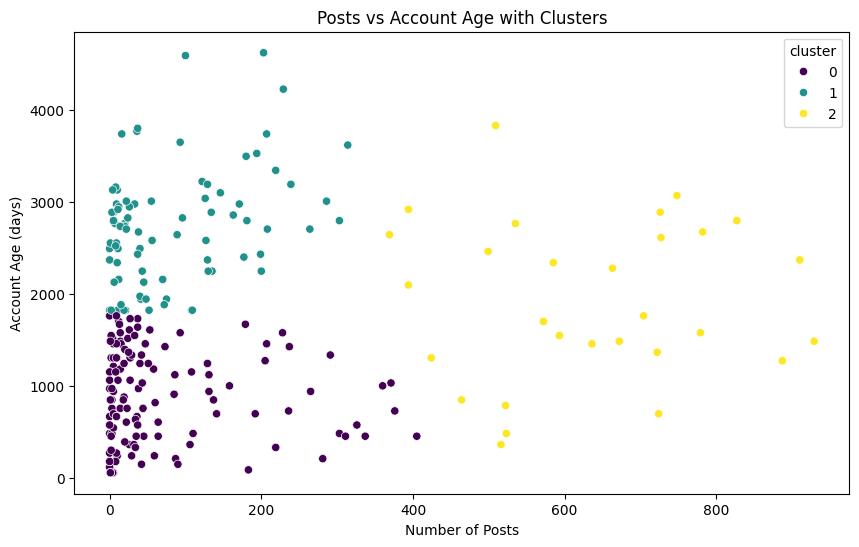

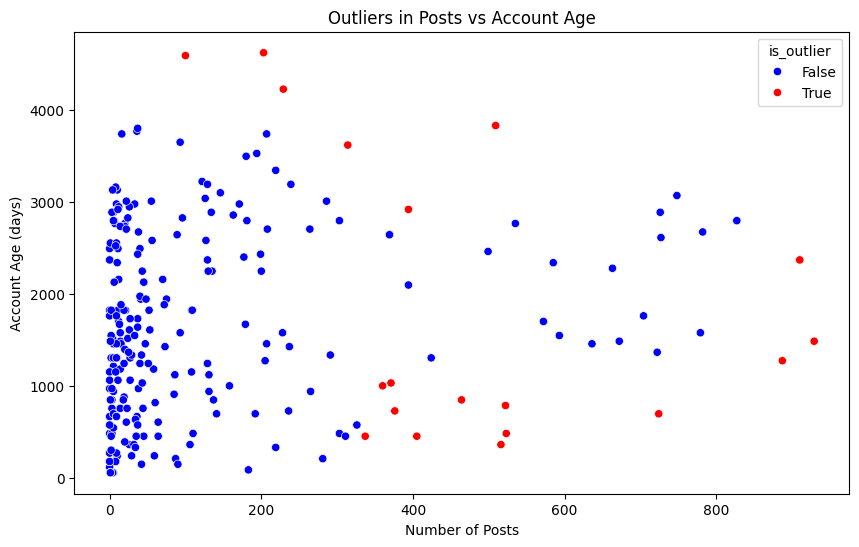

In [22]:
# Plot the clustering results
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x='posts', y='account_age', hue='cluster', palette='viridis', data=df, legend='full')
plt.title('Posts vs Account Age with Clusters')
plt.xlabel('Number of Posts')
plt.ylabel('Account Age (days)')
plt.show()

# Plot the outliers
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x='posts', y='account_age', hue='is_outlier', palette={False: 'blue', True: 'red'}, data=df, legend='full')
plt.title('Outliers in Posts vs Account Age')
plt.xlabel('Number of Posts')
plt.ylabel('Account Age (days)')
plt.show()

In [23]:
# Get the list of outliers
outliers_accounts_pa = df[df['is_outlier'] == True]

# Display the outliers
print(outliers_accounts_pa)

                  user_id                      name  posts  followers  \
18        abbeysarahsingh               Abbey Singh 509.00     194000   
23        abbeysarahsingh               Abbey Singh 509.00     194000   
28       abbyboomofficial                 Abby Boom 203.00     699000   
33          abbielgregory                     Abbie 100.00        533   
39       abbyboomofficial                 Abby Boom 203.00     699000   
72        adah_ki_adah_12  adah____hi adah fan page 523.00        115   
104         adelsvozilova                     𝑨𝒅𝒆𝒍𝒂 229.00       2299   
145    itzzz____qveen____              🌺(⁠✿pooja✿)🌺 376.00        531   
147         kaja.l1239367                     kajal 405.00        402   
173           pooja.55770              pooja sharma 910.00     269000   
216          reenaseema12                     reena 929.00     267000   
221       cute_neha_ricky                 Neha Neha 337.00        251   
241           riya_45cute               riya 45 cut

In [24]:
# Concatenate the two DataFrames to combine outliers
combined_outliers = pd.concat([outliers_accounts_pa, outliers_accounts_ff])

# Remove duplicate entries based on 'user_id'
combined_outliers = combined_outliers.drop_duplicates(subset='user_id')

# Display the combined outliers
print(combined_outliers)

NameError: name 'outliers_accounts_ff' is not defined

In [ ]:
features = ['followers', 'following', 'posts', 'account_age']
X = df[features]

# Convert features to numeric values if they are not already
X = X.apply(pd.to_numeric, errors='coerce')

# Remove rows with NaN values in the relevant columns again after conversion
X.dropna(inplace=True)

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Apply DBSCAN
dbscan = DBSCAN(eps=1, min_samples=5)  # Tune parameters based on your dataset
df['cluster'] = dbscan.fit_predict(X_scaled)

# Identify outliers (DBSCAN labels outliers as -1)
df['is_fake'] = df['cluster'] == -1

# Display the first few rows of the DataFrame to verify the changes
print(df.head())

                user_id          name  posts  followers  following  PVT  \
2  ronaldo_cr7_fan_____          cr 7 131.00     546000          7    0   
4         cr_7.ronalddo  Ronaldo cr.7   5.00        114         11    0   
5              artagael  Abagael West  20.00        111        291    0   
6              abhagael       Abagael  26.00         62        329    0   
7             abagael._      Abagael💋  12.00       1304        620    1   

  date_joined  former_usernames  verified  account_age  ...  is_low_activity  \
2  2022-08-01              4.00         0          938  ...            False   
4  2021-11-01              3.00         0         1211  ...            False   
5  2017-08-01              0.00         0         2764  ...            False   
6  2024-03-01              2.00         0          360  ...            False   
7  2019-04-01              4.00         0         2156  ...            False   

   is_high_activity  fake_username  fake_name  log_followers  log_fo

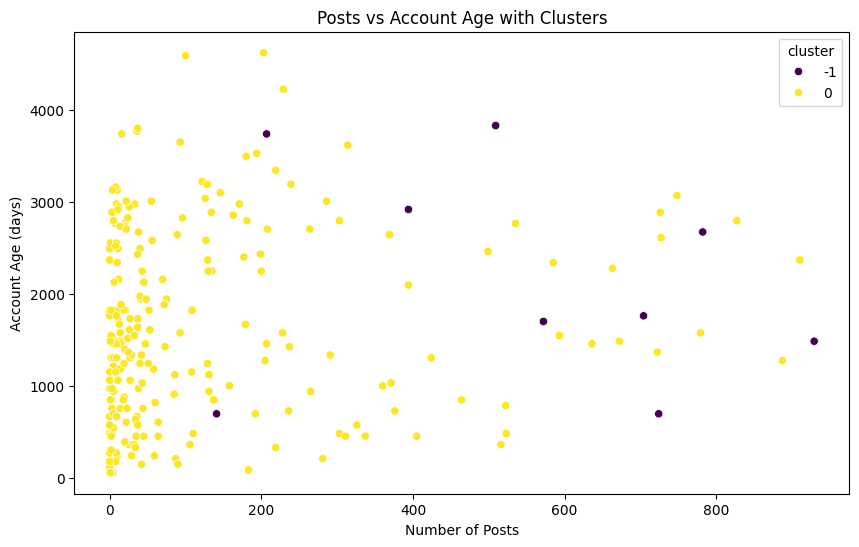

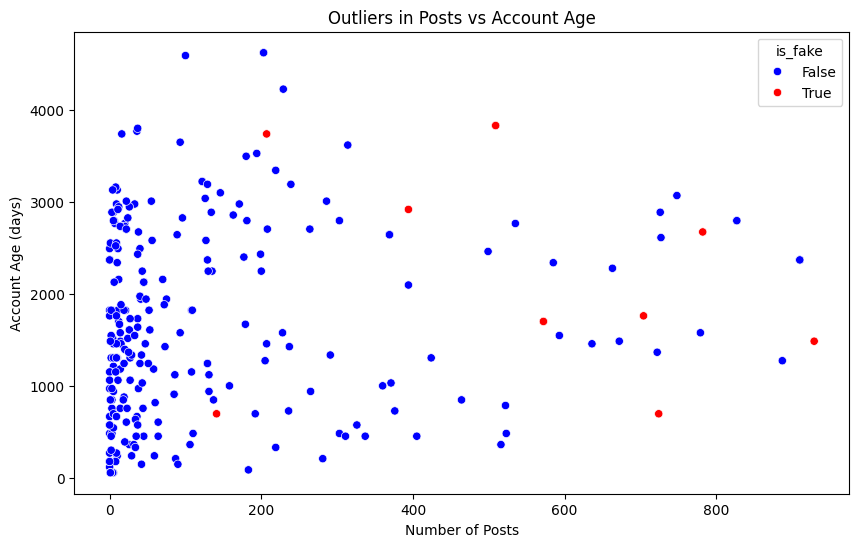

In [ ]:
# Plot the clustering results
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x='posts', y='account_age', hue='cluster', palette='viridis', data=df, legend='full')
plt.title('Posts vs Account Age with Clusters')
plt.xlabel('Number of Posts')
plt.ylabel('Account Age (days)')
plt.show()

# Plot the outliers
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x='posts', y='account_age', hue='is_fake', palette={False: 'blue', True: 'red'}, data=df, legend='full')
plt.title('Outliers in Posts vs Account Age')
plt.xlabel('Number of Posts')
plt.ylabel('Account Age (days)')
plt.show()